# Big Data Analytics

## add names here:




### The aim of this project is to use the IMDB Dataset: (Link) and use data such as actors, director, genre, isAdult and runtime to predict how well a movie will perform. We use the boxoffice and userrating as measures of performance. We will train our model with 80% of the data and test it on the remaining 20%. We will also give our predicitons for upcoming movies that do not have any ratings/boxoffice yet.

### Our hypothesis is that actors & director will positively influence the performance while the variable runtime will negatively influence it. 



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.linear_model import Ridge,LinearRegression,Lasso
from sklearn.neural_network import MLPRegressor
from sklearn.decomposition import PCA
from sklearn.preprocessing import PolynomialFeatures
%matplotlib inline



In [3]:
def join_another(df1,df2, on_col):
    df1['tconst'] = df1['tconst'].astype(str)
    df2['tconst'] = df2['tconst'].astype(str)
    return pd.merge(df1,df2,on=on_col,how="inner")

df = pd.read_csv("./data/boxOffice.csv")

fileNames = [
    'title.basics.tsv',
    'title.crew.tsv',
    "title.principals.tsv",
    "title.ratings.tsv"
    ]
for fileName in fileNames:
    df_to_join = pd.read_csv("./data/"+fileName, sep='\t')
    df = join_another(df,df_to_join,'tconst')

df_to_join = pd.read_csv("./data/name.basics.tsv", sep='\t')
df = pd.merge(df,df_to_join,how='inner',on="nconst")
df_to_join.rename(columns={"nconst":'directors'}, inplace=True)
df = pd.merge(df,df_to_join,how='inner',on=["directors"])
df = df.rename(columns={"primaryName_x":"actor_name","primaryName_y":"director_name"})
df.to_csv("data/allData_unprocessed.csv",index=False)


C:\Users\Ben\Documents\UNIVERSITAET\Master\Semester_2\BigDataAnalytics


C:\Users\Ben\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3147: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,tconst,domestic,international,worldwide,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,...,actor_name,birthYear_x,deathYear_x,primaryProfession_x,knownForTitles_x,director_name,birthYear_y,deathYear_y,primaryProfession_y,knownForTitles_y
0,tt0011216,NaN,NaN,NaN,movie,Spanish Fiesta,La fête espagnole,0,1920,\N,...,Anna Gay,\N,\N,actress,tt0011216,Germaine Dulac,1882,1942,"director,writer,producer","tt0016564,tt0434457,tt0013626,tt0132246"
1,tt0011216,NaN,NaN,NaN,movie,Spanish Fiesta,La fête espagnole,0,1920,\N,...,Ève Francis,1886,1980,"actress,assistant_director,writer","tt0011216,tt0012134,tt0013122,tt0231794",Germaine Dulac,1882,1942,"director,writer,producer","tt0016564,tt0434457,tt0013626,tt0132246"
2,tt0011216,NaN,NaN,NaN,movie,Spanish Fiesta,La fête espagnole,0,1920,\N,...,Gabriel Gabrio,1887,1946,actor,"tt0016112,tt0172720,tt0029453,tt0165229",Germaine Dulac,1882,1942,"director,writer,producer","tt0016564,tt0434457,tt0013626,tt0132246"
3,tt0011216,NaN,NaN,NaN,movie,Spanish Fiesta,La fête espagnole,0,1920,\N,...,Jean Toulout,1887,1962,"actor,writer,director","tt0036665,tt0016112,tt0020182,tt0194139",Germaine Dulac,1882,1942,"director,writer,producer","tt0016564,tt0434457,tt0013626,tt0132246"
4,tt0011216,NaN,NaN,NaN,movie,Spanish Fiesta,La fête espagnole,0,1920,\N,...,Gaston Modot,1887,1970,"actor,writer,director","tt0022235,tt0028950,tt0037674,tt0267971",Germaine Dulac,1882,1942,"director,writer,producer","tt0016564,tt0434457,tt0013626,tt0132246"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
865397,tt9903952,NaN,NaN,NaN,movie,BADMEN with a good behavior,BADMEN with a good behavior,0,2018,\N,...,Tristan Heinen-Bizjak,\N,\N,actor,\N,Loco Meisenkaiser,\N,\N,"director,actor,writer",\N
865398,tt9903952,NaN,NaN,NaN,movie,BADMEN with a good behavior,BADMEN with a good behavior,0,2018,\N,...,Andre Neweling,\N,\N,"cinematographer,editor,producer",tt9903952,Loco Meisenkaiser,\N,\N,"director,actor,writer",\N
865399,tt9904530,NaN,NaN,NaN,movie,Scream Returns,Scream Returns,0,2018,\N,...,Arthur Lang,\N,\N,"actor,camera_department","tt4793796,tt9904530,tt9089510",Jad Charaf,\N,\N,director,\N
865400,tt9904530,NaN,NaN,NaN,movie,Scream Returns,Scream Returns,0,2018,\N,...,Jad Charaf,\N,\N,director,\N,Jad Charaf,\N,\N,director,\N


2


<AxesSubplot:>

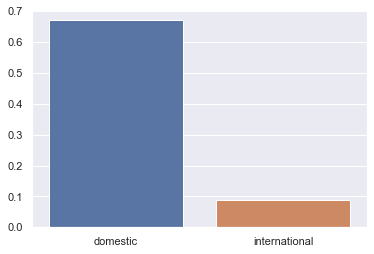

In [124]:
missing_data_ratio = (np.sum(df.isna())/df.shape[0]).sort_values(ascending=False)
print(missing_data_ratio[missing_data_ratio!=0].count())
missing_data_ratio = missing_data_ratio[missing_data_ratio!=0]
sns.set_theme(style="darkgrid")
sns.barplot(x = missing_data_ratio.index, y=missing_data_ratio.values)

Notes:
    - 5 columns contain missing values
    - domestic contains the most

# Load Data and Preprocessing

## title basics 

In [2]:
df = pd.read_csv("data/title.basics.tsv",sep="\t")
# Select all non tv Series
df = df[(df['endYear']=='\\N')]
df.drop(["endYear"],axis=1,inplace=True)
df = df[(df['titleType']=="movie")]
# replace all \N with NAN and subsequently drop them
df.replace("\\N",np.nan,inplace=True)
df.dropna(inplace=True)
# Convert data types to int where feasible
df['startYear'] = df['startYear'].astype(int)
df['isAdult'] = df['isAdult'].astype(int)
df['runtimeMinutes'] = df['runtimeMinutes'].astype(int)

df = df[(df['startYear']>=2000) & (df['startYear']<=2020)]

df.reset_index(inplace=True,drop=True)
df.to_csv("data/title.basics_preprocessed.csv",index=False)
df

/home/flo/anaconda3/envs/datascience/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (4,5) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,runtimeMinutes,genres
0,tt0011216,movie,Spanish Fiesta,La fête espagnole,0,2019,67,Drama
1,tt0016906,movie,Frivolinas,Frivolinas,0,2014,80,"Comedy,Musical"
2,tt0019996,movie,Hongxia,Hongxia,0,2011,94,Action
3,tt0035423,movie,Kate & Leopold,Kate & Leopold,0,2001,118,"Comedy,Fantasy,Romance"
4,tt0036177,movie,Muhomatsu no issho,Muhomatsu no issho,0,2008,100,"Action,Adventure"
...,...,...,...,...,...,...,...,...
189856,tt9916362,movie,Coven,Akelarre,0,2020,92,"Adventure,Drama,History"
189857,tt9916538,movie,Kuambil Lagi Hatiku,Kuambil Lagi Hatiku,0,2019,123,Drama
189858,tt9916622,movie,Rodolpho Teóphilo - O Legado de um Pioneiro,Rodolpho Teóphilo - O Legado de um Pioneiro,0,2015,57,Documentary
189859,tt9916680,movie,De la ilusión al desconcierto: cine colombiano...,De la ilusión al desconcierto: cine colombiano...,0,2007,100,Documentary


## title crew

In [4]:
import os
print(os.getcwd())
print(os.listdir('./data'))
df = pd.read_csv('./data/title.crew.tsv', sep= '\t', header=0)
df.drop(['writers'], axis=1, inplace=True)
print(df['directors'].isnull().values.any())
df.to_csv("data/title.crew_preprocessed.csv",index=False)
df

/home/flo/Documents/FS2021/Big Data Analytics/gitRepo/BigDataAnalytics
['boxOffice_preprocessed.csv', 'title.crew_preprocessed.csv', 'README.md', 'title.crew.tsv', 'title.basics.tsv', 'tconsts.csv', 'name.basics.tsv', 'title.akas.tsv', 'title.principals.tsv', 'title.basics_preprocessed.csv', 'archive', 'boxOffice.csv', 'title.ratings.tsv', 'title.ratings.csv']
False


,tconst,directors
0,tt0000001,nm0005690
1,tt0000002,nm0721526
2,tt0000003,nm0721526
3,tt0000004,nm0721526
4,tt0000005,nm0005690
...,...,...
7869181,tt9916848,"nm5519454,nm5519375"
7869182,tt9916850,"nm5519375,nm5519454"
7869183,tt9916852,"nm5519454,nm5519375"
7869184,tt9916856,nm10538645


# title.akas

In [7]:
df = pd.read_csv("data/title.akas.tsv","\t",usecols=['titleId','language','isOriginalTitle'])
df

/home/flo/anaconda3/envs/datascience/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,titleId,language,isOriginalTitle
0,tt0000001,\N,0
1,tt0000001,\N,0
2,tt0000001,\N,0
3,tt0000001,\N,0
4,tt0000001,\N,0
...,...,...,...
26152127,tt9916852,ja,0
26152128,tt9916852,pt,0
26152129,tt9916852,it,0
26152130,tt9916852,hi,0


In [8]:
df = df[df["isOriginalTitle"]==1]
np.unique(df["language"])

array(['\\N', 'ca', 'da', 'en', 'ja'], dtype=object)

## name basics 

In [5]:
df = pd.read_csv("data/name.basics.tsv",sep="\t")
# Drop unnecessary columns
df.drop(["birthYear", "deathYear","primaryProfession","knownForTitles"],axis=1,inplace=True)
# replace all \N with NAN and subsequently drop them
df.replace("\\N",np.nan,inplace=True)
df.dropna(inplace=True)

df.reset_index(inplace=True,drop=True)
df.to_csv("data/name.basics_preprocessed.csv",index=False)
df

,nconst,primaryName
0,nm0000001,Fred Astaire
1,nm0000002,Lauren Bacall
2,nm0000003,Brigitte Bardot
3,nm0000004,John Belushi
4,nm0000005,Ingmar Bergman
...,...,...
10900082,nm9993714,Romeo del Rosario
10900083,nm9993716,Essias Loberg
10900084,nm9993717,Harikrishnan Rajan
10900085,nm9993718,Aayush Nair


## title principals

In [6]:
df = pd.read_csv("data/title.principals.tsv",sep="\t")
# Drop unnecessary columns
df.drop(["ordering", "category","job","characters"],axis=1,inplace=True)
# replace all \N with NAN and subsequently drop them
df.replace("\\N",np.nan,inplace=True)
df.dropna(inplace=True)

df.reset_index(inplace=True,drop=True)
df.to_csv("data/title.principals_preprocessed.csv",index=False)
df

,tconst,nconst
0,tt0000001,nm1588970
1,tt0000001,nm0005690
2,tt0000001,nm0374658
3,tt0000002,nm0721526
4,tt0000002,nm1335271
...,...,...
44505357,tt9916880,nm0996406
44505358,tt9916880,nm1482639
44505359,tt9916880,nm2586970
44505360,tt9916880,nm1594058


## title ratings

In [25]:
df = pd.read_csv("data/title.ratings.tsv", sep ="\t")
# Drop unnecessary columns
df.drop(["numVotes"], axis = 1, inplace = True)
df.dropna(inplace = True)

df.reset_index(inplace=True, drop=True)
df.to_csv("data/title.ratings_preprocessed.csv", index=False)
df

,tconst,averageRating
0,tt0000001,5.7
1,tt0000002,6.1
2,tt0000003,6.5
3,tt0000004,6.1
4,tt0000005,6.1
...,...,...
1148469,tt9916682,5.6
1148470,tt9916690,6.6
1148471,tt9916720,6.5
1148472,tt9916766,6.9


## Box Office Data

In [9]:
df = pd.read_csv("data/boxOffice.csv")
df.dropna(how="all",subset=["domestic","international","worldwide"],inplace=True)
df.reset_index(inplace=True,drop=True)
df.to_csv("data/boxOffice_preprocessed.csv",index=False)
df

# Joining Data

In [57]:
def join_another(df1,df2, on_col):
    df1['tconst'] = df1['tconst'].astype(str)
    df2['tconst'] = df2['tconst'].astype(str)
    return pd.merge(df1,df2,on=on_col,how="inner")


df = pd.read_csv("data/boxOffice_preprocessed.csv")

fileNames = [
    'title.basics_preprocessed.csv',
    'title.crew_preprocessed.csv',
    "title.principals_preprocessed.csv",
    "title.ratings_preprocessed.csv"
    ]
for fileName in fileNames:
    df_to_join = pd.read_csv("data/"+fileName)
    df = join_another(df,df_to_join,'tconst')

df_to_join = pd.read_csv("data/name.basics_preprocessed.csv")
df = pd.merge(df,df_to_join,how='inner',on="nconst")
df_to_join.rename(columns={"nconst":'directors'})
df = pd.merge(df,df_to_join,how='inner',on=["directors"])
df = df.rename(columns={"primaryName_x":"actor_name","primaryName_y":"director_name"})
df.to_csv("data/allData.csv",index=False)
df


,tconst,domestic,international,worldwide,titleType,primaryTitle,originalTitle,isAdult,startYear,runtimeMinutes,genres,directors,nconst,averageRating
0,tt0035423,47121859.0,28897189.0,76019048.0,movie,Kate & Leopold,Kate & Leopold,0,2001,118,"Comedy,Fantasy,Romance",nm0003506,nm0107463,6.4
1,tt0035423,47121859.0,28897189.0,76019048.0,movie,Kate & Leopold,Kate & Leopold,0,2001,118,"Comedy,Fantasy,Romance",nm0003506,nm0000212,6.4
2,tt0035423,47121859.0,28897189.0,76019048.0,movie,Kate & Leopold,Kate & Leopold,0,2001,118,"Comedy,Fantasy,Romance",nm0003506,nm0413168,6.4
3,tt0035423,47121859.0,28897189.0,76019048.0,movie,Kate & Leopold,Kate & Leopold,0,2001,118,"Comedy,Fantasy,Romance",nm0003506,nm0000630,6.4
4,tt0035423,47121859.0,28897189.0,76019048.0,movie,Kate & Leopold,Kate & Leopold,0,2001,118,"Comedy,Fantasy,Romance",nm0003506,nm0005227,6.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
335759,tt9905412,NaN,4791.0,4791.0,movie,Ottam,Ottam,0,2019,120,Drama,nm10533890,nm10533890,7.3
335760,tt9905412,NaN,4791.0,4791.0,movie,Ottam,Ottam,0,2019,120,Drama,nm10533890,nm10533895,7.3
335761,tt9905412,NaN,4791.0,4791.0,movie,Ottam,Ottam,0,2019,120,Drama,nm10533890,nm6546398,7.3
335762,tt9905412,NaN,4791.0,4791.0,movie,Ottam,Ottam,0,2019,120,Drama,nm10533890,nm6412514,7.3


# Preprocessing whole data set

In [87]:
df = pd.read_csv("data/allData.csv")
df.drop('Unnamed: 0', axis=1,inplace=True)
df

,tconst,domestic,international,worldwide,titleType,primaryTitle,originalTitle,isAdult,startYear,runtimeMinutes,genres,directors,nconst,averageRating,actor_name,director_name
0,tt0035423,47121859.0,28897189.0,76019048.0,movie,Kate & Leopold,Kate & Leopold,0,2001,118,"Comedy,Fantasy,Romance",nm0003506,nm0107463,6.4,David Brenner,James Mangold
1,tt0309698,52159536.0,38100000.0,90259536.0,movie,Identity,Identity,0,2003,90,"Mystery,Thriller",nm0003506,nm0107463,7.3,David Brenner,James Mangold
2,tt0035423,47121859.0,28897189.0,76019048.0,movie,Kate & Leopold,Kate & Leopold,0,2001,118,"Comedy,Fantasy,Romance",nm0003506,nm0000212,6.4,Meg Ryan,James Mangold
3,tt0035423,47121859.0,28897189.0,76019048.0,movie,Kate & Leopold,Kate & Leopold,0,2001,118,"Comedy,Fantasy,Romance",nm0003506,nm0413168,6.4,Hugh Jackman,James Mangold
4,tt1430132,132556852.0,282271394.0,414828246.0,movie,The Wolverine,The Wolverine,0,2013,126,"Action,Sci-Fi",nm0003506,nm0413168,6.7,Hugh Jackman,James Mangold
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
305036,tt9859758,NaN,40271.0,40271.0,movie,Ali & Alia,Ali and Alia,0,2019,105,"Drama,Romance",nm10513748,nm4544891,5.2,Neven Madi,Hussein Alansari
305037,tt9859758,NaN,40271.0,40271.0,movie,Ali & Alia,Ali and Alia,0,2019,105,"Drama,Romance",nm10513748,nm10528618,5.2,Sawsan Saad,Hussein Alansari
305038,tt9859758,NaN,40271.0,40271.0,movie,Ali & Alia,Ali and Alia,0,2019,105,"Drama,Romance",nm10513748,nm10513748,5.2,Hussein Alansari,Hussein Alansari
305039,tt9859758,NaN,40271.0,40271.0,movie,Ali & Alia,Ali and Alia,0,2019,105,"Drama,Romance",nm10513748,nm10513749,5.2,Saeed Bughazyain,Hussein Alansari


## Feature Description
### Continuous Features:
#### domestic, international, worldwide 
- values between 13 and 2847246203

#### runtimeMinutes
- values between 45 and 808

#### averageRating
- values between 1 and 9.8

### Categorical Features:
#### genres
- 23 different categories, plan to apply one-hot-encoding

#### actor_name, director_name
- 143108 actors 17272 directors
- plan to gather data on most popular actors/directors and apply binary feature if they are involved with the film.

#### isAdult
- only 46 films set to True, therefore plan on dropping feature

In [138]:
boxoffice_df = df.copy()
boxoffice_df.drop('domestic', axis=1,inplace=True)
boxoffice_df.drop('international', axis=1,inplace=True)
boxoffice_df.dropna(inplace=True)
year_boxoffice = boxoffice_df.groupby(boxoffice_df['startYear'].sort_values())['worldwide'].transform('median')
boxoffice_df['median_boxoffice_pyear'] = year_boxoffice
graphdata = boxoffice_df[['startYear','median_boxoffice_pyear']].drop_duplicates().sort_values('startYear')

plt.figure(figsize=(12,8))
sns.lineplot(x=graphdata['startYear'], y=graphdata['median_boxoffice_pyear'])
plt.show()

KeyError: "['domestic'] not found in axis"

<Figure size 864x576 with 0 Axes>

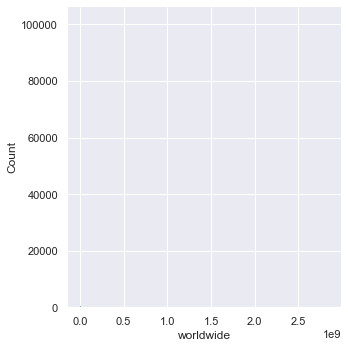

In [137]:
plt.figure(figsize=(12,8))
sns.displot(boxoffice_df['worldwide'])
plt.show()

C:\Users\Ben\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


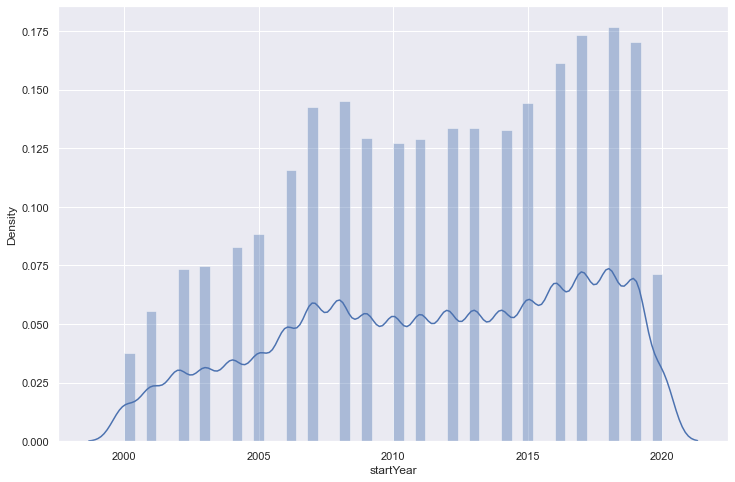

In [135]:
plt.figure(figsize=(12,8))
sns.distplot(boxoffice_df['startYear'])
plt.show()

C:\Users\Ben\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


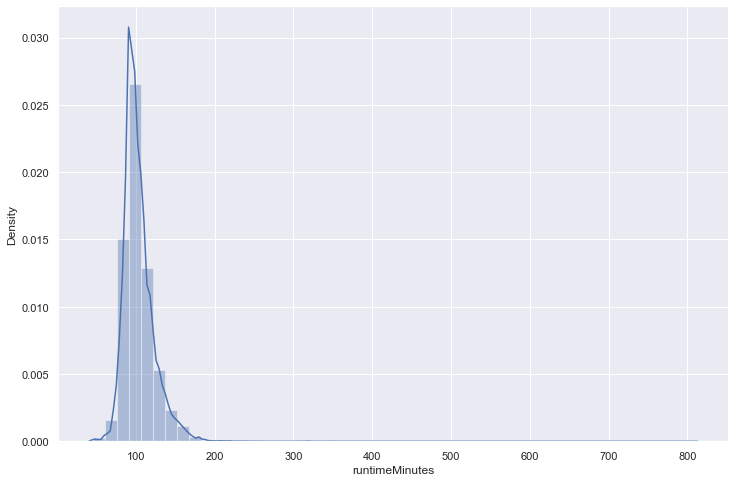

In [136]:
plt.figure(figsize=(12,8))
sns.distplot(boxoffice_df['runtimeMinutes'])
plt.show()

C:\Users\Ben\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


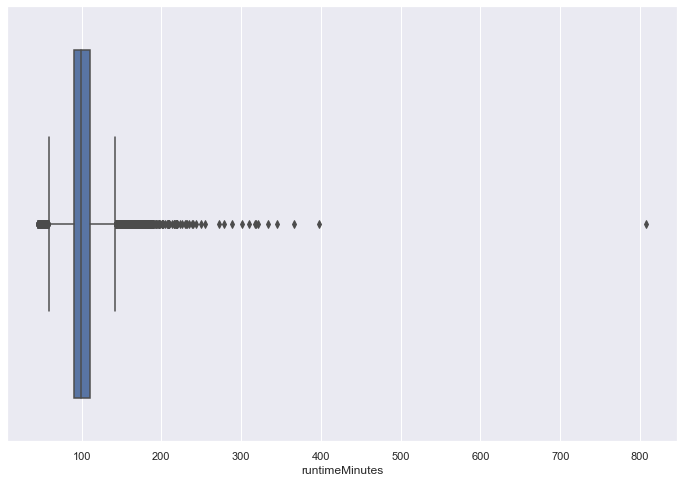

          tconst  worldwide primaryTitle  startYear  runtimeMinutes  \
25873  tt9047474     4032.0      La Flor       2016             808   

       averageRating  Animation  Action  Sci-Fi  Fantasy  ...  News  Sport  \
25873            7.6          0       0       0        0  ...     0      0   

       Biography  Thriller  Drama  War  Musical  Documentary  has_good_actor  \
25873          0         0      0    0        0            0               0   

       has_good_director  
25873                  0  

[1 rows x 31 columns]


In [143]:
plt.figure(figsize=(12,8))
sns.boxplot(boxoffice_df['runtimeMinutes'])
plt.show()
print(df[df['runtimeMinutes'] > 700])

## One hot encode genres

In [35]:

genres = np.unique(df['genres'])
genreset = set()
for genre in genres:
    for g in genre.split(","):
        genreset.add(g)

print(genreset)
print(len(genreset))
for i in genreset:
    df[i] = 0


{'Crime', 'Sci-Fi', 'Thriller', 'Musical', 'Western', 'News', 'Fantasy', 'Documentary', 'Family', 'Comedy', 'Mystery', 'Animation', 'Adventure', 'Drama', 'Adult', 'History', 'Action', 'War', 'Music', 'Romance', 'Biography', 'Horror', 'Sport'}
23


In [36]:
df[df['startYear']>=2017].shape


(72183, 39)

In [37]:
df

,tconst,domestic,international,worldwide,titleType,primaryTitle,originalTitle,isAdult,startYear,runtimeMinutes,...,Drama,Adult,History,Action,War,Music,Romance,Biography,Horror,Sport
0,tt0035423,47121859.0,28897189.0,76019048.0,movie,Kate & Leopold,Kate & Leopold,0,2001,118,...,0,0,0,0,0,0,0,0,0,0
1,tt0309698,52159536.0,38100000.0,90259536.0,movie,Identity,Identity,0,2003,90,...,0,0,0,0,0,0,0,0,0,0
2,tt0035423,47121859.0,28897189.0,76019048.0,movie,Kate & Leopold,Kate & Leopold,0,2001,118,...,0,0,0,0,0,0,0,0,0,0
3,tt0035423,47121859.0,28897189.0,76019048.0,movie,Kate & Leopold,Kate & Leopold,0,2001,118,...,0,0,0,0,0,0,0,0,0,0
4,tt1430132,132556852.0,282271394.0,414828246.0,movie,The Wolverine,The Wolverine,0,2013,126,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
305036,tt9859758,NaN,40271.0,40271.0,movie,Ali & Alia,Ali and Alia,0,2019,105,...,0,0,0,0,0,0,0,0,0,0
305037,tt9859758,NaN,40271.0,40271.0,movie,Ali & Alia,Ali and Alia,0,2019,105,...,0,0,0,0,0,0,0,0,0,0
305038,tt9859758,NaN,40271.0,40271.0,movie,Ali & Alia,Ali and Alia,0,2019,105,...,0,0,0,0,0,0,0,0,0,0
305039,tt9859758,NaN,40271.0,40271.0,movie,Ali & Alia,Ali and Alia,0,2019,105,...,0,0,0,0,0,0,0,0,0,0


In [21]:
unique_tconst= df['tconst'].unique()
best_actors = pd.read_csv("./data/top_actors.csv")
best_directors = pd.read_csv('./data/nominated_directors.csv')

In [22]:
df['has_good_actor'] = 0
df['has_good_director'] = 0
best_actors = best_actors['top_actors'].to_list()
best_directors = best_directors['nominated_directors'].to_list()

In [24]:
print(len(unique_tconst))

31799


In [34]:
for const in range(len(unique_tconst)):
    print(const)
    df2 = df[df['tconst'] == unique_tconst[const]]
    found_actor=0
    found_director=0
    for i in df2.index:
        if found_actor and found_director:
            break
        if not found_actor and df2.at[i,'actor_name'] in best_actors:
            found_actor=1
        if not found_director and df2.at[i,'director_name'] in best_directors:
            found_director=1
    df.loc[df2.index,-2] = found_actor
    df.loc[df2.index,-1]=found_director
    

5
28466
28467
28468
28469
28470
28471
28472
28473
28474
28475
28476
28477
28478
28479
28480
28481
28482
28483
28484
28485
28486
28487
28488
28489
28490
28491
28492
28493
28494
28495
28496
28497
28498
28499
28500
28501
28502
28503
28504
28505
28506
28507
28508
28509
28510
28511
28512
28513
28514
28515
28516
28517
28518
28519
28520
28521
28522
28523
28524
28525
28526
28527
28528
28529
28530
28531
28532
28533
28534
28535
28536
28537
28538
28539
28540
28541
28542
28543
28544
28545
28546
28547
28548
28549
28550
28551
28552
28553
28554
28555
28556
28557
28558
28559
28560
28561
28562
28563
28564
28565
28566
28567
28568
28569
28570
28571
28572
28573
28574
28575
28576
28577
28578
28579
28580
28581
28582
28583
28584
28585
28586
28587
28588
28589
28590
28591
28592
28593
28594
28595
28596
28597
28598
28599
28600
28601
28602
28603
28604
28605
28606
28607
28608
28609
28610
28611
28612
28613
28614
28615
28616
28617
28618
28619
28620
28621
28622
28623
28624
28625
28626
28627
28628
28629
28630
28631
28

1280

In [37]:
#drop actors, directors
df.drop_duplicates(subset='tconst', inplace=True,ignore_index=True)
# drop duplicate rows

In [41]:
df.columns

Index([           'tconst',          'domestic',     'international',
               'worldwide',         'titleType',      'primaryTitle',
           'originalTitle',           'isAdult',         'startYear',
          'runtimeMinutes',            'genres',         'directors',
                  'nconst',     'averageRating',        'actor_name',
           'director_name',         'Animation',            'Action',
                  'Sci-Fi',           'Fantasy',            'Horror',
                 'Mystery',         'Adventure',             'Crime',
                   'Adult',            'Family',           'Western',
                 'Romance',            'Comedy',             'Music',
                 'History',              'News',             'Sport',
               'Biography',          'Thriller',             'Drama',
                     'War',           'Musical',       'Documentary',
          'has_good_actor', 'has_good_director',                  -2,
                    

In [47]:
df.drop(["domestic","international","titleType","genres","directors","nconst","actor_name","isAdult","originalTitle","director_name",-2,-1],axis=1,inplace=True)


In [50]:
df.to_csv("data/allData_preprocessed.csv",index=False)

# Correlation

<AxesSubplot:>

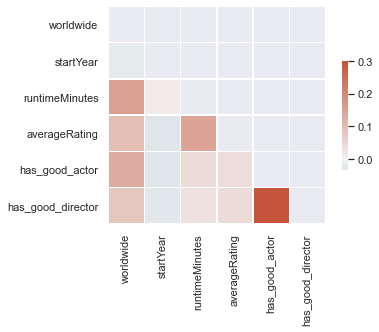

In [141]:
corr = df[['worldwide','startYear','runtimeMinutes','averageRating','has_good_actor','has_good_director']].corr(method='pearson')
mask = np.triu(np.ones_like(corr, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

# Data Preprocessing

## Steps performed

### dropping columns, imputing missing values, categorical datapoints


In [16]:
x = df[df['primaryTitle']=="Kate & Leopold"]
np.unique(x['actor_name'])

array(['Breckin Meyer', 'Cathy Konrad', 'David Brenner', 'Hugh Jackman',
       'James Mangold', 'Liev Schreiber', 'Meg Ryan', 'Rolfe Kent',
       'Steven Rogers', 'Stuart Dryburgh'], dtype=object)

In [131]:
df = pd.read_csv("data/allData_preprocessed.csv")
print(df.columns)
df.head()

Index(['tconst', 'worldwide', 'primaryTitle', 'startYear', 'runtimeMinutes',
       'averageRating', 'Animation', 'Action', 'Sci-Fi', 'Fantasy', 'Horror',
       'Mystery', 'Adventure', 'Crime', 'Adult', 'Family', 'Western',
       'Romance', 'Comedy', 'Music', 'History', 'News', 'Sport', 'Biography',
       'Thriller', 'Drama', 'War', 'Musical', 'Documentary', 'has_good_actor',
       'has_good_director'],
      dtype='object')


,tconst,worldwide,primaryTitle,startYear,runtimeMinutes,averageRating,Animation,Action,Sci-Fi,Fantasy,...,News,Sport,Biography,Thriller,Drama,War,Musical,Documentary,has_good_actor,has_good_director
0,tt0035423,76019048.0,Kate & Leopold,2001,118,6.4,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,tt0309698,90259536.0,Identity,2003,90,7.3,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,tt1430132,414828246.0,The Wolverine,2013,126,6.7,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,tt3315342,619179950.0,Logan,2017,137,8.1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,tt0358273,186797986.0,Walk the Line,2005,136,7.8,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


# Kfold to decrease potential overfitting

In [4]:
from sklearn.model_selection import KFold

def kfold_validation(X,y,model,n_splits=5):
    start = time.time()
    kf = KFold(n_splits=n_splits,shuffle=True, random_state=69420) 
    mses = []
    models = []
    count = 0
    for trainIndices,testIndices in kf.split(X):
        print(f"iteration: {count}")
        Xtrain,Xval = X[trainIndices,:],X[testIndices,:]
        ytrain,yval = y[trainIndices],y[testIndices]
        model.fit(Xtrain,ytrain)
        yhat = model.predict(Xval)
        mse = np.sum(np.square(yval-yhat))/yval.size # mean squared error
        mses.append(mse)
        models.append(model)
        count+=1
    print(f"time used (seconds): {time.time()-start}")
    return mses, models


# Standardise to make data more comparable

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
def expand_basis(X, degree):
    poly = PolynomialFeatures(degree,interaction_only=True)
    X = poly.fit_transform(X)
    return X 
def prepare_data(X1, degree): 
    scaler = StandardScaler() 
    scaler.fit(X1)
    X1 = expand_basis(scaler.transform(X1),degree) 
    return X1

In [40]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

#X = df.loc[:, df.columns != 'worldwide']
#X.drop(["primaryTitle","tconst","startYear"],axis=1,inplace=True) 
#y = df["worldwide"]

X = df.loc[:, df.columns != 'averageRating']
X.drop(["primaryTitle","tconst","startYear"],axis=1,inplace=True) 
y = df["averageRating"]
y = df["worldwide"]

X = X.to_numpy()
y = y.to_numpy()
#X = prepare_data(X,2)
Xtrain,Xtest, ytrain,ytest = train_test_split(X,y,shuffle=True,train_size=0.8)

def standardise_data(X):
    mean = np.mean(X)
    std = np.std(X)
    X_std = (X-mean)/std
    return X_std, mean, std

#kf = KFold(n_splits=1,shuffle=True, random_state=69420) 

Xtrain_std, X_train_mean, X_train_std_div = standardise_data(Xtrain)
Xtest_std = (Xtest-X_train_mean)/X_train_std_div


/home/flo/anaconda3/envs/datascience/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [33]:
print(Xtrain.shape)
print(Xtest.shape)

(25439, 379)
(6360, 379)


# Linear Regression

In [41]:
model = LinearRegression()
mses,models = kfold_validation(Xtrain,ytrain,model,5)
yhat=models[np.argmin(mses)].predict(Xtest)
np.mean(np.square(yhat-ytest))

iteration: 0
iteration: 1
iteration: 2
iteration: 3
iteration: 4
time used (seconds): 0.08403992652893066


2.6475648772808855e-15

# Ridge Regression

In [35]:
from sklearn.linear_model import Ridge

alphaList = [0.0001,0.001,0.01,0.1,1,10,100]
results = []
for alpha in alphaList:
    model = Ridge(alpha=alpha)
    mses,models = kfold_validation(Xtrain,ytrain,model,5)
    yhat=models[np.argmin(mses)].predict(Xtest)
    results.append(np.mean(np.square(yhat-ytest)))
    


iteration: 0
iteration: 1
iteration: 2
iteration: 3
iteration: 4
time used (seconds): 0.8540246486663818
iteration: 0
iteration: 1
iteration: 2
iteration: 3
iteration: 4
time used (seconds): 0.867436408996582
iteration: 0
iteration: 1
iteration: 2
iteration: 3
iteration: 4
time used (seconds): 0.8670570850372314
iteration: 0
iteration: 1
iteration: 2
iteration: 3
iteration: 4
time used (seconds): 0.8893523216247559
iteration: 0
iteration: 1
iteration: 2
iteration: 3
iteration: 4
time used (seconds): 0.83840012550354
iteration: 0
iteration: 1
iteration: 2
iteration: 3
iteration: 4
time used (seconds): 0.830183744430542
iteration: 0
iteration: 1
iteration: 2
iteration: 3
iteration: 4
time used (seconds): 0.8366971015930176


In [36]:
for i in range(len(alphaList)):
    print(f"{alphaList[i]}: {results[i]}")

0.0001: 0.5114337721517762
0.001: 51.14336881129276
0.01: 5114.320586808996
0.1: 511415.5985589831
1: 51125102.975163035
10: 5096096684.614229
100: 493618885837.80865


In [37]:
from sklearn.linear_model import Lasso

alphaList = [0.0001,0.001,0.01,0.1,1,10,100]
results = []
for alpha in alphaList:
    model = Ridge(alpha=alpha)
    mses,models = kfold_validation(Xtrain,ytrain,model,5)
    yhat=models[np.argmin(mses)].predict(Xtest)
    results.append(np.mean(np.square(yhat-ytest)))


iteration: 0
iteration: 1
iteration: 2
iteration: 3
iteration: 4
time used (seconds): 0.8517236709594727
iteration: 0
iteration: 1
iteration: 2
iteration: 3
iteration: 4
time used (seconds): 0.8609178066253662
iteration: 0
iteration: 1
iteration: 2
iteration: 3
iteration: 4
time used (seconds): 0.8361387252807617
iteration: 0
iteration: 1
iteration: 2
iteration: 3
iteration: 4
time used (seconds): 0.7257635593414307
iteration: 0
iteration: 1
iteration: 2
iteration: 3
iteration: 4
time used (seconds): 0.7203655242919922
iteration: 0
iteration: 1
iteration: 2
iteration: 3
iteration: 4
time used (seconds): 0.6441946029663086
iteration: 0
iteration: 1
iteration: 2
iteration: 3
iteration: 4
time used (seconds): 0.6074850559234619


In [38]:
for i in range(len(alphaList)):
    print(f"{alphaList[i]}: {results[i]}")

0.0001: 0.5114337721517762
0.001: 51.14336881129276
0.01: 5114.320586808996
0.1: 511415.5985589831
1: 51125102.975163035
10: 5096096684.614229
100: 493618885837.80865


In [42]:
from sklearn.naive_bayes import GaussianNB

model = GaussianNB()
mses,models = kfold_validation(Xtrain,ytrain,model,5)
yhat=models[np.argmin(mses)].predict(Xtest)
np.mean(np.square(yhat-ytest))

iteration: 0
iteration: 1
iteration: 2
iteration: 3
iteration: 4
time used (seconds): 76.769611120224


# Random Forest

In [39]:
from sklearn.ensemble import RandomForestRegressor 

model = RandomForestRegressor()
mses,models = kfold_validation(Xtrain,ytrain,model)
yhat=models[np.argmin(mses)].predict(Xtest)
np.mean(np.square(yhat-ytest))


iteration: 0
iteration: 1
iteration: 2
iteration: 3
iteration: 4
time used (seconds): 110.99794840812683


162078968952764.75

# Data Visualisation

In [66]:
from sklearn.svm import SVC  

model = SVC()
mses,models = kfold_validation(Xtrain,ytrain,model)
yhat=models[np.argmin(mses)].predict(Xtest)
np.mean(np.square(yhat-ytest))

iteration: 0
